## DECENTRALIZED INVENTORY MODEL FOR AMAZON FULFILLMENT CENTERS

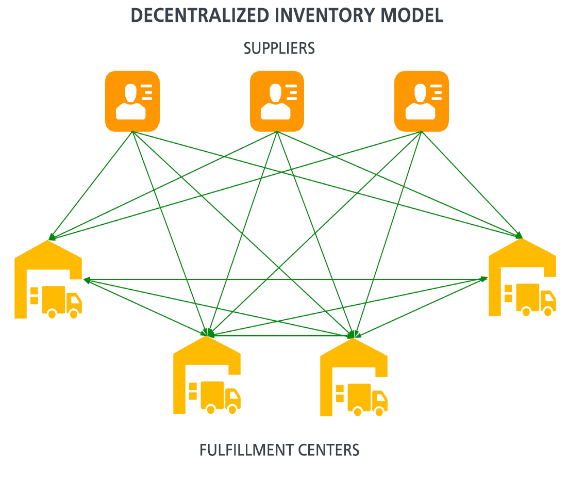

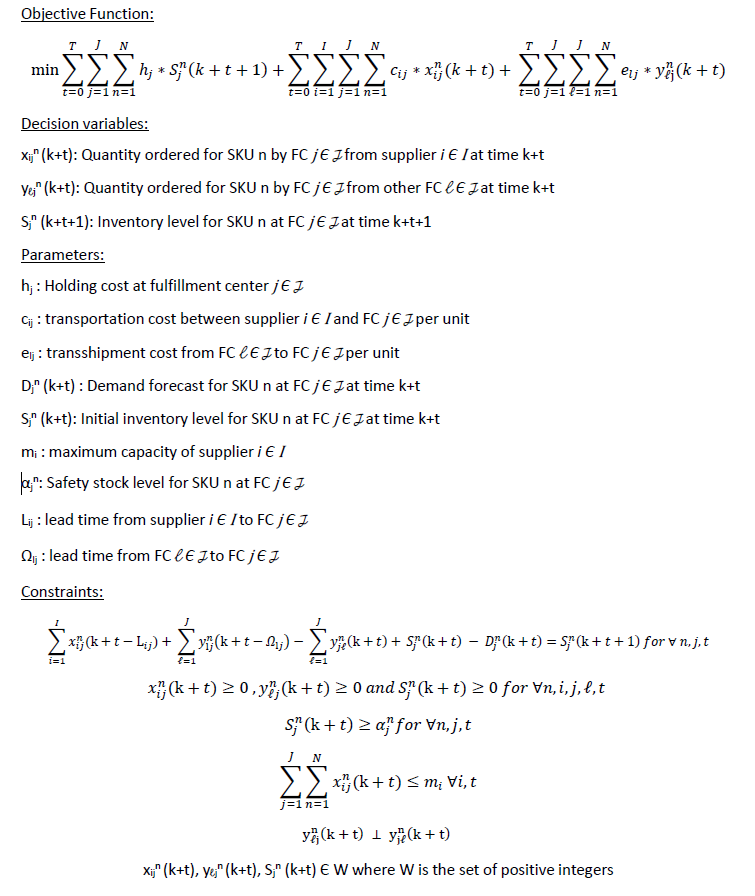

In [ ]:
import gurobipy as gp
import numpy as np
import pandas as pd

In [ ]:
dec_stock = pd.read_excel('Dec_2022_Stock Level.xlsx')
dec_forecast = pd.read_excel('Dec_2022_Forecast & Consumption.xlsx')
dec_safetystock = pd.read_excel('Dec_2022_SafetyStock Level.xlsx')
supplier_capacity = pd.read_excel('Dec_2022_Supplier Capacity.xlsx')
fc_loc = pd.read_excel('FC_Loc.xlsx')
supplier_loc = pd.read_excel('Supplier_Loc.xlsx')

In [ ]:
!pip install folium

In [ ]:
!pip install geopy

In [ ]:
#Location Map: Blue:FC, Green: Supplier

import folium
import pandas as pd

# Create a map centered on a specific location
map_center = [34.1, -117.9]  # Specify the center coordinates
map_zoom = 9  # Specify the initial zoom level

# Create a map object
map_object = folium.Map(location=map_center, zoom_start=map_zoom, min_zoom=4, max_zoom=10)


# Define the coordinates you want to plot from fc_loc DataFrame
fc_coordinates = fc_loc[['latitude', 'longitude', 'FC']].values

# Define the coordinates you want to plot from supplier_loc DataFrame
supplier_coordinates = supplier_loc[['latitude', 'longitude', 'UniqueID']].values

# Plot the fc_loc coordinates on the map as blue circles with FC name
for coordinate in fc_coordinates:
    circle_marker = folium.CircleMarker(
        location=[coordinate[0], coordinate[1]],
        radius=4,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=coordinate[2]  # Use the FC name column as the popup value
    )
    circle_marker.add_to(map_object)

# Plot the supplier_loc coordinates on the map as green circles with supplier name inside
for coordinate in supplier_coordinates:
    html = f'<div style="text-align: center;"><span style="font-weight: bold; color: green;">{coordinate[2]}</span></div>'
    circle_marker = folium.CircleMarker(
        location=[coordinate[0], coordinate[1]],
        radius=4,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8,
        popup=folium.Popup(html, max_width=200)  # Use supplier name as HTML content in the popup
    )
    circle_marker.add_to(map_object)

# Display the map
map_object.save("map.html")  # Save the map as an HTML file
map_object  # Display the map in Jupyter Notebook


In [ ]:
import pandas as pd
from geopy.distance import distance

In [ ]:
num_fcs = len(fc_loc)
num_suppliers = len(supplier_loc)
num_products = len(dec_forecast['Item'].unique())
num_periods = len(dec_forecast['Date'].unique())

In [ ]:
from geopy.distance import distance

# Distance Matrix from Supplier to FC
transport_distance_matrix = np.zeros((num_suppliers, num_fcs, num_periods , num_products))

# Calculate the distances between each FC and supplier
for date_idx, date in enumerate(dec_forecast['Date'].unique()):
    for product_idx in range(num_products):
        for fc_idx, fc_row in fc_loc.iterrows():
            fc_coords = (fc_row['latitude'], fc_row['longitude'])
            for supplier_idx, supplier_row in supplier_loc.iterrows():
                supplier_coords = (supplier_row['latitude'], supplier_row['longitude'])
                transport_distance_matrix[supplier_idx, fc_idx, date_idx, product_idx] = distance(supplier_coords, fc_coords).km

# Print the new shape of the repeated distance matrix
print(transport_distance_matrix)


In [ ]:
# Distance Matrix from FC to FC

# Create an empty matrix to hold the distances

tranship_distance_matrix = np.zeros((num_fcs, num_fcs, num_periods, num_products))

# Calculate the distances between each FC and FC
for date_idx, date in enumerate(dec_forecast['Date'].unique()):
  for product_idx in range(num_products):
    for fc_idx, fc_row in fc_loc.iterrows():
        fc_coords = (fc_row['latitude'], fc_row['longitude'])
        for fc_idx2, fc_row2 in fc_loc.iterrows():
            fc_coords2 = (fc_row2['latitude'], fc_row2['longitude'])
            tranship_distance_matrix[fc_idx, fc_idx2, date_idx, product_idx] = distance(fc_coords, fc_coords2).km

# Print the distance matrix
print(tranship_distance_matrix)


In [ ]:
# Stock level in FCs

# Extract the unique dates from the "Date" column
dec_dates = dec_stock['Date'].unique()

# Create an empty dictionary to hold the stock levels for each FC, product, and date
stock_levels = {}

# Iterate over the unique dates
for date in dec_dates:
    # Filter the DataFrame for the current date
    filtered_data = dec_stock[dec_stock['Date'] == date]
    
    # Create a dictionary to hold the stock levels for each FC, product on the current date
    stock_levels[date] = {}
    
    # Iterate over each row in the filtered DataFrame
    for _, row in filtered_data.iterrows():
        # Get the FC, product, and stock level
        fc = row['FC']
        product = row['Item']
        stock = row['Stock']
        
        # Create a nested dictionary for the FC if it doesn't exist
        if fc not in stock_levels[date]:
            stock_levels[date][fc] = {}
        
        # Store the stock level for the current FC, product, and date in the dictionary
        stock_levels[date][fc][product] = stock

# Create a NumPy array to hold the stock levels for all FCs, products, and dates
stock_level_np = np.zeros((len(dec_dates), num_fcs, num_products))

# Iterate over the stock levels dictionary and populate the NumPy array
for date_idx, date in enumerate(dec_dates):
    for fc_idx, fc_row in fc_loc.iterrows():
        fc = fc_row['FC']
        for product_idx, product in enumerate(dec_forecast['Item'].unique()):
            stock_level_np[date_idx, fc_idx, product_idx] = stock_levels[date].get(fc, {}).get(product, 0)

print(stock_level_np[0])


In [ ]:
# Safety stock level required in FCs for each period

# Extract the unique dates from the "Date" column
dec_dates = dec_safetystock['Date'].unique()

# Create an empty list to store the nested lists
safetystock_level = []

# Iterate over the unique dates
for date in dec_dates:
    # Filter the DataFrame for rows matching the current date
    filtered_data = dec_safetystock[dec_safetystock['Date'] == date]

    # Create a dictionary to hold the safety stock levels for each FC, product on the current date
    safetystock_levels_date = {}

    # Iterate over each row in the filtered DataFrame
    for _, row in filtered_data.iterrows():
        # Get the FC, product, and safety stock level
        fc = row['FC']
        product = row['Item']
        safetystock = row['SafetyStock']

        # Create a nested dictionary for the FC if it doesn't exist
        if fc not in safetystock_levels_date:
            safetystock_levels_date[fc] = {}

        # Store the safety stock level for the current FC, product, and date in the dictionary
        safetystock_levels_date[fc][product] = safetystock

    # Append the dictionary of safety stock levels to the main list
    safetystock_level.append(safetystock_levels_date)

# Create a NumPy array to hold the safety stock levels for all FCs, products, and dates
safetystock_level_np = np.zeros((len(dec_dates), num_fcs, num_products))

# Iterate over the list of safety stock levels and populate the NumPy array
for date_idx, safetystock_levels_date in enumerate(safetystock_level):
    for fc_idx, fc_row in fc_loc.iterrows():
        fc = fc_row['FC']
        for product_idx, product in enumerate(dec_forecast['Item'].unique()):
            safetystock_level_np[date_idx, fc_idx, product_idx] = safetystock_levels_date.get(fc, {}).get(product, 0)

print(safetystock_level_np)


In [ ]:
# Forecast levels in FCs

# Extract the unique dates from the "Date" column
dec_dates = dec_forecast['Date'].unique()

# Create an empty dictionary to hold the forecast details for each product, FC, and date
forecast_level = {}

# Iterate over the unique dates
for date in dec_dates:
    # Filter the DataFrame for the current date
    filtered_data = dec_forecast[dec_forecast['Date'] == date]

    # Create a dictionary to hold the forecast details for each FC, product on the current date
    forecast_level[date] = {}

    # Iterate over each row in the filtered DataFrame
    for _, row in filtered_data.iterrows():
        # Get the FC, product, and forecast details
        fc = row['FC']
        product = row['Item']
        forecast = row['Forecast']

        # Create a nested dictionary for the FC if it doesn't exist
        if fc not in forecast_level[date]:
            forecast_level[date][fc] = {}

        # Store the forecast details for the current FC, product, and date in the dictionary
        forecast_level[date][fc][product] = forecast

# Create a NumPy array to hold the forecast details for all FCs, products, and dates
forecast_level_np = np.zeros((len(dec_dates), num_fcs, num_products))

# Iterate over the forecast details dictionary and populate the NumPy array
for date_idx, date in enumerate(dec_dates):
    for fc_idx, fc_row in fc_loc.iterrows():
        fc = fc_row['FC']
        for product_idx, product in enumerate(dec_forecast['Item'].unique()):
            forecast_level_np[date_idx, fc_idx, product_idx] = forecast_level[date].get(fc, {}).get(product, 0)

print(forecast_level_np)


In [ ]:
# Maximum capacity of suppliers for each period

# Extract the unique dates from the "Date" column
dec_dates = supplier_capacity['Date'].unique()

# Create an empty list to store the nested dictionaries
max_capacity_list = []

# Iterate over the unique dates
for date in dec_dates:
    # Filter the DataFrame for rows matching the current date
    filtered_data = supplier_capacity[supplier_capacity['Date'] == date]

    # Create a dictionary to hold the maximum capacity levels for each supplier, product on the current date
    supplier_capacity_date = {}

    # Iterate over each row in the filtered DataFrame
    for _, row in filtered_data.iterrows():
        # Get the supplier, product, and capacity
        supplier = row['Supplier']
        product = row['Item']
        capacity = row['Capacity']

        # Create a nested dictionary for the supplier if it doesn't exist
        if supplier not in supplier_capacity_date:
            supplier_capacity_date[supplier] = {}

        # Store the maximum capacity level for the current supplier, product, and date in the dictionary
        supplier_capacity_date[supplier][product] = capacity

    # Append the dictionary of maximum capacity levels to the main list
    max_capacity_list.append(supplier_capacity_date)

# Determine the number of unique suppliers and products
num_suppliers = len(supplier_loc)
num_products = len(supplier_capacity['Item'].unique())

# Create a NumPy array to hold the maximum capacity levels for all suppliers, products, and dates
supplier_capacity_np = np.zeros((len(dec_dates), num_suppliers, num_products))

# Iterate over the list of maximum capacity levels and populate the NumPy array
for date_idx, supplier_capacity_date in enumerate(max_capacity_list):
    for supplier_idx, supplier_row in supplier_loc.iterrows():
        supplier = supplier_row['UniqueID']
        for product_idx, product in enumerate(supplier_capacity['Item'].unique()):
            supplier_capacity_np[date_idx, supplier_idx, product_idx] = supplier_capacity_date.get(supplier, {}).get(product, 0)

print(supplier_capacity_np)


In [ ]:

# KEY PARAMETERS

# Inventory value per unit of all products are assumed to be 1 $. 
# Holding cost is considered to be 15% of Inventory value per annum (15 cents per year). 
# Per km transport cost for truck in US is approximatly 1 $.
# Consiering a truck load of 10,000 units we arrive at 0.0001 $ per unit per km.
# Leadtimes are mentioned in days

holding_cost_per_day_per_unit = (0.15/365)
transport_cost_per_km_per_unit = (1/10000)
tranship_cost_per_km_per_unit = (1/10000)
leadtime_fc = 0
leadtime_supplier = 2


In [ ]:
tranship_cost = tranship_distance_matrix * tranship_cost_per_km_per_unit # between FCs

In [ ]:
transport_cost = transport_distance_matrix * transport_cost_per_km_per_unit # between Suppliers and FCs

In [ ]:
num_supplier = len(supplier_loc)
num_fc = len(fc_loc)  
num_period = len(dec_forecast['Date'].unique())
num_product = len(dec_forecast['Item'].unique())

model = gp.Model()

**Optimization with transshipment between FCs are calculated in the following part**

In [ ]:
x = model.addMVar((num_supplier, num_fc, num_period, num_product), lb=0, vtype=gp.GRB.INTEGER) # amount of order from suppliers
y = model.addMVar((num_fc, num_fc, num_period, num_product), lb=0, vtype=gp.GRB.INTEGER) # amount of order from other FCs
s = model.addMVar((num_period, num_fc, num_product), lb=0, vtype=gp.GRB.INTEGER) # FC inventory level

In [ ]:
# Objective function

model.setObjective((holding_cost_per_day_per_unit * s).sum() + (transport_cost * x).sum() + (tranship_cost * y).sum(), sense=gp.GRB.MINIMIZE)

In [ ]:
# Setting initial stock levels

model.addConstrs((s[0,j,n] == stock_level_np[0,j,n] for j in range(num_fc) for n in range(num_product)))

In [ ]:
# Safety stock constraint

model.addConstrs(safetystock_level_np[k,j,n] <= s[k,j,n] for k in range(num_period) for j in range(num_fc) for n in range(num_product))

In [ ]:
# Maximum Supplier Capacity constraint

model.addConstrs(supplier_capacity_np[k,i,n] >= (sum(x[i, j, k, n] for j in range(num_fc))) 
                  for k in range(num_period) for i in range(num_supplier) for n in range(num_product))

In [ ]:
# Constraint for limiting the FC from ordering its own stock

model.addConstrs(y[l, j, k, n] == 0 for l in range(num_fc) for j in range(num_fc) for k in range(num_period) for n in range(num_product) if l == j)

In [ ]:
# X + Y - Y + S - D == S(+1) Constraint to calculate Stock for next time period- for k >= leadtimes

model.addConstrs((sum(x[i, j, k-leadtime_supplier, n] for i in range(num_supplier)) + sum(y[l, j, k-leadtime_fc, n] for l in range(num_fc)) 
                  - sum(y[j, l, k, n] for l in range(num_fc))+ s[k, j, n] - forecast_level_np[k, j, n] == s[(k + 1), j, n]) 
                  for k in range(num_period-1) for j in range(num_fc) for n in range(num_product) if k>=leadtime_supplier and k>=leadtime_fc)


In [ ]:
# S - Y - D == S(+1) Constraint to calculate Stock for next time period for k < leadtimes

model.addConstrs(( s[k, j, n] - sum(y[j, l, k, n] for l in range(num_fc)) - forecast_level_np[k, j, n] == s[(k + 1), j, n]) 
                  for k in range(num_period-1) for j in range(num_fc) for n in range(num_product) if k<leadtime_supplier and k<leadtime_fc)


In [ ]:
# S + Y - Y - D == S(+1) Constraint to calculate Stock for next time period for k < leadtime_supplier and k >= leadtime_fc

model.addConstrs(( s[k, j, n] + sum(y[l, j, k-leadtime_fc, n] for l in range(num_fc)) - sum(y[j, l, k, n] for l in range(num_fc)) 
                  - forecast_level_np[k, j, n] == s[(k + 1), j, n]) for k in range(num_period-1) for j in range(num_fc) 
                  for n in range(num_product) if k < leadtime_supplier and k >= leadtime_fc)


In [ ]:
# S + X - Y - D == S(+1) Constraint to calculate Stock for next time period for k < leadtime_fc and k >= leadtime_supplier

model.addConstrs(( s[k, j, n] + sum(x[i, j, k-leadtime_supplier, n] for i in range(num_supplier)) - sum(y[j, l, k, n] for l in range(num_fc)) 
                  - forecast_level_np[k, j, n] == s[(k + 1), j, n]) for k in range(num_period-1) 
                  for j in range(num_fc) for n in range(num_product) if k < leadtime_fc and k >= leadtime_supplier)


In [ ]:
model.optimize()

# Check the optimization status
if model.status == gp.GRB.OPTIMAL:
    # Retrieve the objective value
    obj_value = model.objVal
    print("Objective value:", obj_value)
else:
    print("Optimization did not converge to an optimal solution.")

In [ ]:
x_opt = x.X
y_opt = y.X
s_opt = s.X

if model.status == gp.GRB.OPTIMAL:
    print("Optimized order qty from Supplier to FC:")
    print(x_opt)
    print("Optimized order qty from FC to FC:")
    print(y_opt)
    print("Optimized inventory level for FC:")
    print(s_opt)
else:
    print("The problem is infeasible or unbounded.")

**Optimization without transshipment between FCs are calculated in the following part**

In [ ]:
x2 = model.addMVar((num_supplier, num_fc, num_period, num_product), lb=0, vtype=gp.GRB.INTEGER) # amount of order from suppliers without transshipment
s2 = model.addMVar((num_period, num_fc, num_product), lb=0, vtype=gp.GRB.INTEGER) # FC inventory level without transshipment

In [ ]:
# Objective function for withhout transshipment

model.setObjective((holding_cost_per_day_per_unit * s2).sum() + (transport_cost * x2).sum() , sense=gp.GRB.MINIMIZE)

In [ ]:
# Setting initial stock levels for withhout transshipment

model.addConstrs((s2[0,j,n] == stock_level_np[0,j,n] for j in range(num_fc) for n in range(num_product)))

In [ ]:
# Safety stock constraint for withhout transshipment

model.addConstrs(safetystock_level_np[k,j,n] <= s2[k,j,n] for k in range(num_period) for j in range(num_fc) for n in range(num_product))

In [ ]:
# Maximum Supplier Capacity constraint for withhout transshipment

model.addConstrs(supplier_capacity_np[k,i,n] >= (sum(x2[i, j, k, n] for j in range(num_fc))) 
                  for k in range(num_period) for i in range(num_supplier) for n in range(num_product))

In [ ]:
# X + S - D == S(+1) Constraint to calculate Stock for next time period- for k >= leadtime_supplier for withhout transshipment

model.addConstrs((sum(x2[i, j, k-leadtime_supplier, n] for i in range(num_supplier)) + s2[k, j, n] - forecast_level_np[k, j, n] == s2[(k + 1), j, n]) 
                  for k in range(num_period-1) for j in range(num_fc) for n in range(num_product) if k >= leadtime_supplier)


In [ ]:
# S - D == S(+1) Constraint to calculate Stock for next time period for k < leadtime_supplier for withhout transshipment

model.addConstrs(( s2[k, j, n] - forecast_level_np[k, j, n] == s2[(k + 1), j, n]) 
                  for k in range(num_period-1) for j in range(num_fc) for n in range(num_product) if k < leadtime_supplier)

In [ ]:
model.optimize()

# Check the optimization status
if model.status == gp.GRB.OPTIMAL:
    # Retrieve the objective value
    obj_value_without_transshipment = model.objVal
    print("Objective value:", obj_value_without_transshipment)
else:
    print("Optimization did not converge to an optimal solution.")

In [ ]:
x2_opt = x2.X
s2_opt = s2.X

if model.status == gp.GRB.OPTIMAL:
    print("Optimized order qty from Supplier to FC:")
    print(x2_opt)
    print("Optimized inventory level for FC:")
    print(s2_opt)
else:
    print("The problem is infeasible or unbounded.")

**Cost incurred by Amazon for current order quantities & stock levels are calculated below**

In [ ]:
# Actual ordered qty in FCs

# Extract the unique dates from the "Date" column
dec_dates = dec_forecast['Date'].unique()

# Create an empty dictionary to hold the stock levels for each FC, product, and date
order_levels = {}

# Iterate over the unique dates
for date in dec_dates:
    # Filter the DataFrame for the current date
    filtered_data = dec_forecast[dec_forecast['Date'] == date]
    
    # Create a dictionary to hold the order qty for each FC, product on the current date
    order_levels[date] = {}
    
    # Iterate over each row in the filtered DataFrame
    for _, row in filtered_data.iterrows():
        # Get the FC, product, and order level
        fc = row['FC']
        product = row['Item']
        order_qty = row['Ordered']
        
        # Create a nested dictionary for the FC if it doesn't exist
        if fc not in order_levels[date]:
            order_levels[date][fc] = {}
        
        # Store the order qty for the current FC, product, and date in the dictionary
        order_levels[date][fc][product] = order_qty

# Create a NumPy array to hold the stock levels for all FCs, products, and dates
order_level_np = np.zeros((len(dec_dates), num_fcs, num_products))

# Iterate over the stock levels dictionary and populate the NumPy array
for date_idx, date in enumerate(dec_dates):
    for fc_idx, fc_row in fc_loc.iterrows():
        fc = fc_row['FC']
        for product_idx, product in enumerate(dec_forecast['Item'].unique()):
            order_level_np[date_idx, fc_idx, product_idx] = order_levels[date].get(fc, {}).get(product, 0)

print(order_level_np)


In [ ]:
min_distance_3d = np.min(transport_distance_matrix, axis=0)
# Transpose the array
min_distance_3d_T = np.transpose(min_distance_3d, (1, 0, 2))

obj_value_existing = ((holding_cost_per_day_per_unit * stock_level_np).sum() + (min_distance_3d_T* order_level_np*transport_cost_per_km_per_unit).sum())
obj_value_existing

**Comparisons of actual cost, optimized cost without transshipment, and optimized cost with transshipment are as follows:**

In [ ]:
import plotly.graph_objects as go

# Define the variable names
variable_names = ['Current Cost', 'Opt Cost (Without Transshipment)','Opt Cost (With Transshipment)' ]

# Define the values
values = [(obj_value_existing/1000000), (obj_value_without_transshipment/1000000), (obj_value/1000000) ]

# Create a bar trace
trace = go.Bar(
    x=variable_names,
    y=values,
    texttemplate='%{y:,.2f}M',
    textposition='auto',
)

# Create the layout
layout = go.Layout(
    title='Cost Comparison',
    xaxis=dict(title='Output'),
    yaxis=dict(title='Cost (In Millions)'),
    width=500,
    height=500,
    plot_bgcolor='white'
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the chart
fig.show()


**Downloading the optimzation outputs in excel**

In [ ]:
# Define the period, supplier, and FC labels
periods = dec_forecast['Date'].unique()
suppliers = supplier_loc['UniqueID'].values
fcs = fc_loc['FC'].values
products = dec_forecast['Item'].unique()

# Initialize the output DataFrame
output = pd.DataFrame(columns=['Period','Product', 'Supplier', 'From_FC', 'To_FC', 'Quantity_Shipped'])

# Iterate over the optimized order quantities from FC to Supplier
for period_idx in range(num_period):
  for product_idx in range(num_product):
    for supplier_idx in range(num_supplier):
        for fc_idx in range(num_fc):
            quantity = x_opt[supplier_idx, fc_idx, period_idx, product_idx]
            if quantity > 0:
                new_row = pd.DataFrame({'Period': periods[period_idx],
                                        'Product':products[product_idx],
                                        'Supplier': suppliers[supplier_idx],
                                        'To_FC': fcs[fc_idx],
                                        'Quantity_Shipped': quantity}, index=[0])
                output = pd.concat([output, new_row], ignore_index=True)

# Iterate over the optimized order quantities from FC to FC
for period_idx in range(num_period):
  for product_idx in range(num_product):
    for from_fc_idx in range(num_fc):
        for to_fc_idx in range(num_fc):
            quantity = y_opt[from_fc_idx, to_fc_idx, period_idx, product_idx]
            if quantity > 0:
                new_row = pd.DataFrame({'Period': periods[period_idx],
                                        'Product':products[product_idx],
                                        'From_FC': fcs[from_fc_idx],
                                        'To_FC': fcs[to_fc_idx],
                                        'Quantity_Shipped': quantity}, index=[0])
                output = pd.concat([output, new_row], ignore_index=True)

# Save the output to a CSV file
output.to_csv('optimization_output_with_transshipment.csv', index=False)


In [ ]:
# Define the period, supplier, and FC labels
periods = dec_forecast['Date'].unique()
suppliers = supplier_loc['UniqueID'].values
fcs = fc_loc['FC'].values
products = dec_forecast['Item'].unique()

# Initialize the output DataFrame
output = pd.DataFrame(columns=['Period','Product', 'Supplier', 'To_FC', 'Quantity_Shipped'])

# Iterate over the optimized order quantities from FC to Supplier
for period_idx in range(num_period):
  for product_idx in range(num_product):
    for supplier_idx in range(num_supplier):
        for fc_idx in range(num_fc):
            quantity = x2_opt[supplier_idx, fc_idx, period_idx, product_idx]
            if quantity > 0:
                new_row = pd.DataFrame({'Period': periods[period_idx],
                                        'Product':products[product_idx],
                                        'Supplier': suppliers[supplier_idx],
                                        'To_FC': fcs[fc_idx],
                                        'Quantity_Shipped': quantity}, index=[0])
                output = pd.concat([output, new_row], ignore_index=True)



# Save the output to a CSV file
output.to_csv('optimization_output_without_transshipment.csv', index=False)


In [ ]:
# Define the period, supplier, and FC labels
periods = dec_forecast['Date'].unique()
suppliers = supplier_loc['UniqueID'].values
fcs = fc_loc['FC'].values
products = dec_forecast['Item'].unique()

# Initialize the output DataFrame
output = pd.DataFrame(columns=['Period','FC', 'Product','Stock'])

# Iterate over the optimized order quantities from FC to Supplier
for period_idx in range(num_period):
    for product_idx in range(num_product):
        for fc_idx in range(num_fc):
            stock = s_opt[period_idx, fc_idx, product_idx]
            if stock > 0:
                new_row = pd.DataFrame({'Period': periods[period_idx],
                                        'FC': fcs[fc_idx],
                                        'Product': products[product_idx],
                                        'Stock': stock}, index=[0])
                output = pd.concat([output, new_row], ignore_index=True)

# Save the output to a CSV file
output.to_csv('stock_level_with_transshipment.csv', index=False)


In [ ]:
# Define the period, supplier, and FC labels
periods = dec_forecast['Date'].unique()
suppliers = supplier_loc['UniqueID'].values
fcs = fc_loc['FC'].values
products = dec_forecast['Item'].unique()

# Initialize the output DataFrame
output = pd.DataFrame(columns=['Period','FC', 'Product','Stock'])

# Iterate over the optimized order quantities from FC to Supplier
for period_idx in range(num_period):
    for product_idx in range(num_product):
        for fc_idx in range(num_fc):
            stock = s2_opt[period_idx, fc_idx, product_idx]
            if stock > 0:
                new_row = pd.DataFrame({'Period': periods[period_idx],
                                        'FC': fcs[fc_idx],
                                        'Product': products[product_idx],
                                        'Stock': stock}, index=[0])
                output = pd.concat([output, new_row], ignore_index=True)

# Save the output to a CSV file
output.to_csv('stock_level_without_transshipment.csv', index=False)


In [ ]:
#All seperate cost values for optimized centralized model with transshipment

holding_cost_fc_with_trans = (holding_cost_per_day_per_unit * s_opt).sum()
transportation_cost_supplier_to_fc_with_trans = (transport_cost * x_opt).sum()
transshipment_cost_with_trans = (tranship_cost * y_opt).sum()
total_cost_with_trans = obj_value
total_products_stored_fc_with_trans = (s_opt).sum()
total_products_shipped_from_supplier_with_trans = (x_opt).sum()
total_products_shipped_from_fc_with_trans = (y_opt).sum()

#All seperate cost values for optimized centralized model without transshipment

holding_cost_fc_without_trans = (holding_cost_per_day_per_unit * s2_opt).sum()
transportation_cost_supplier_to_fc_without_trans = (transport_cost * x2_opt).sum()
total_cost_without_trans = obj_value_without_transshipment
total_products_stored_fc_without_trans = (s2_opt).sum()
total_products_shipped_from_supplier_without_trans = (x2_opt).sum()

#All seperate cost values for current situation 

holding_cost_fc_current = (holding_cost_per_day_per_unit * stock_level_np).sum()
transportation_cost_current = (min_distance_3d_T* order_level_np*transport_cost_per_km_per_unit).sum()
total_cost_current = obj_value_existing
total_products_stored_fc_current = (stock_level_np).sum()
total_products_shipped_from_supplier_current = (order_level_np).sum()

In [ ]:
!pip install openpyxl

import openpyxl

# Parameters and Cost values
values = {
    "Holding Cost FC per day per unit": holding_cost_per_day_per_unit,
    "Transportation cost per km per unit": transport_cost_per_km_per_unit,
    "Transshipment cost per km per unit": tranship_cost_per_km_per_unit,
    "Leadtime FC": leadtime_fc,
    "Leadtime Supplier": leadtime_supplier,
    "Holding cost FC with transshipment": holding_cost_fc_with_trans,
    "Transportation cost supplier to CenterFC with transshipment": transportation_cost_supplier_to_fc_with_trans,
    "Transshipment cost with transshipment": transshipment_cost_with_trans,
    "Total cost with transshipment": total_cost_with_trans,
    "Total products stored at all FCs with transshipment":total_products_stored_fc_with_trans,
    "Total products shipped from supplier with transshipment":total_products_shipped_from_supplier_with_trans,
    "Total products shipped from FCs with transshipment":total_products_shipped_from_fc_with_trans,
    "Holding cost FC without transshipment": holding_cost_fc_without_trans,
    "Transportation cost supplier to FC without transshipment": transportation_cost_supplier_to_fc_without_trans,
    "Total cost without transshipment": total_cost_without_trans,
    "Total products stored at all FCs without transshipment":total_products_stored_fc_without_trans,
    "Total products shipped from supplier without transshipment":total_products_shipped_from_supplier_without_trans,
    "Holding cost FC current": holding_cost_fc_current,
    "Transportation cost supplier to FC current": transportation_cost_current,
    "Total cost current": total_cost_current,
    "Total products stored at FCs current":total_products_stored_fc_current,
    "Total products shipped from supplier current":total_products_shipped_from_supplier_current
}

workbook = openpyxl.Workbook()
worksheet = workbook.active

# Write headers
worksheet.cell(row=1, column=1).value = "Parameter"
worksheet.cell(row=1, column=2).value = "Value"

# Write values to Excel
for index, (parameter, value) in enumerate(values.items(), start=2):
    worksheet.cell(row=index, column=1).value = parameter
    worksheet.cell(row=index, column=2).value = value

# Save the Excel workbook
workbook.save("output_costs_and_parameters.xlsx")